In [1]:
from arcade_dataset import load_dataset, visualize_batch
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision.utils import make_grid
import torch
from torch.utils.data import DataLoader
from model import VesselSegmentationModel
from tqdm.notebook import tqdm
import wandb

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

### Label Distribution

In [3]:
label_dist_split = 'train'

In [4]:
train_dataset = load_dataset(label_dist_split)

In [ ]:
# Plot a grid of the mean label, for each label
label_means = torch.zeros_like(train_dataset[0]['separate_masks'])
for i in range(len(train_dataset)):
    label_means += train_dataset[i]['separate_masks']
label_means /= len(train_dataset)

In [137]:
labels_grid = make_grid(label_means.unsqueeze(1), nrow=5, normalize=True, scale_each=True).permute(1, 2, 0)

In [138]:
H_cell, W_cell = labels_grid.size(0) // 5, labels_grid.size(1) // 5 
grid_size = 5

def create_hued_square(hue, height, width):
    # Create an image with the given hue
    img = Image.new('HSV', (width, height), (int(hue), 255, 255))
    img = img.convert('RGB')
    return np.array(img).transpose(2, 0, 1)

# Create a list of hued squares
squares = []
for i in range(grid_size * grid_size):
    hue = (i / (grid_size * grid_size)) * 200 # Distribute hues evenly
    square = create_hued_square(hue, H_cell, W_cell)
    squares.append(square)

# Convert list of squares to a tensor
squares_tensor = torch.tensor(squares)

# Create the grid
color_grid = torch.tensor(make_grid(squares_tensor, nrow=grid_size).numpy().transpose(1, 2, 0))
color_grid = color_grid[:labels_grid.size(0), :labels_grid.size(1)]

In [139]:
color_grid.size(), labels_grid.mean(-1).unsqueeze(-1).size()

(torch.Size([2572, 2572, 3]), torch.Size([2572, 2572, 1]))

In [140]:
color_grid = color_grid / 255.0

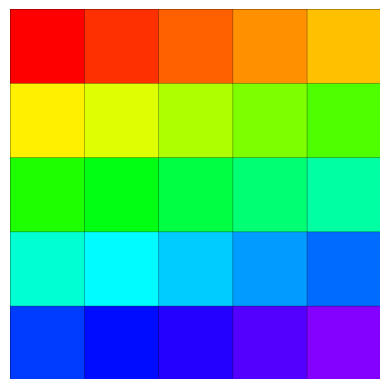

In [143]:
plt.imshow(color_grid)
plt.axis('off')
plt.show()

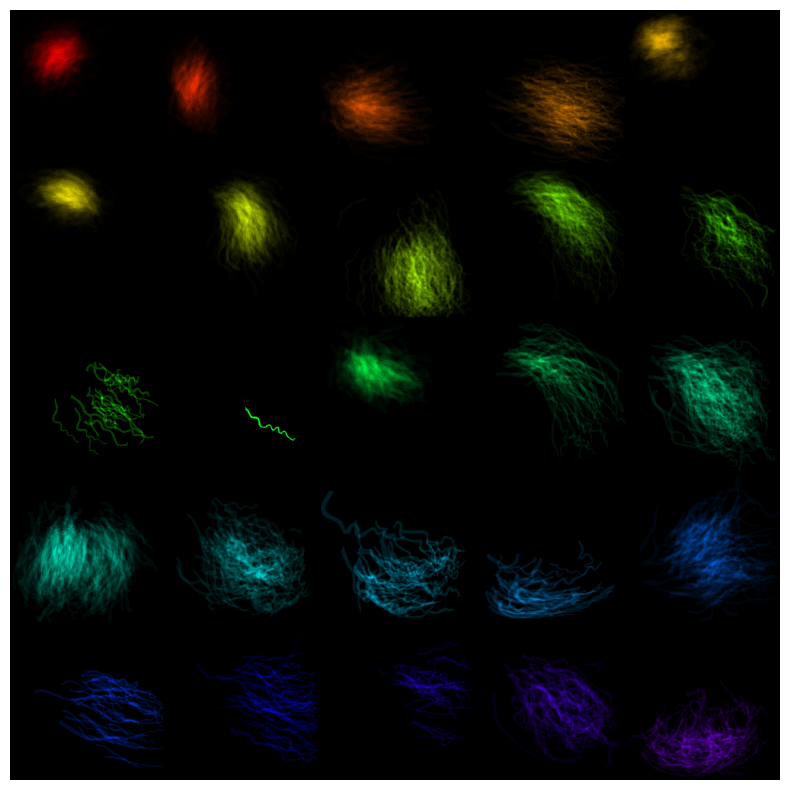

In [144]:
plt.figure(figsize=(10, 10))
plt.imshow(labels_grid.mean(-1).unsqueeze(-1) * color_grid)
plt.axis('off')
plt.savefig('plots/vessel_distribution_{label_dist_split}.svg', format='svg', bbox_inches='tight')
plt.show()

### Visualize Batch

In [3]:
dataset = load_dataset(split='val')
next(iter(dataset)).keys()
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
batch = next(iter(dataloader))

In [4]:
batch['original_image'].max(), batch['original_image'].min()

(tensor(255.), tensor(0.))

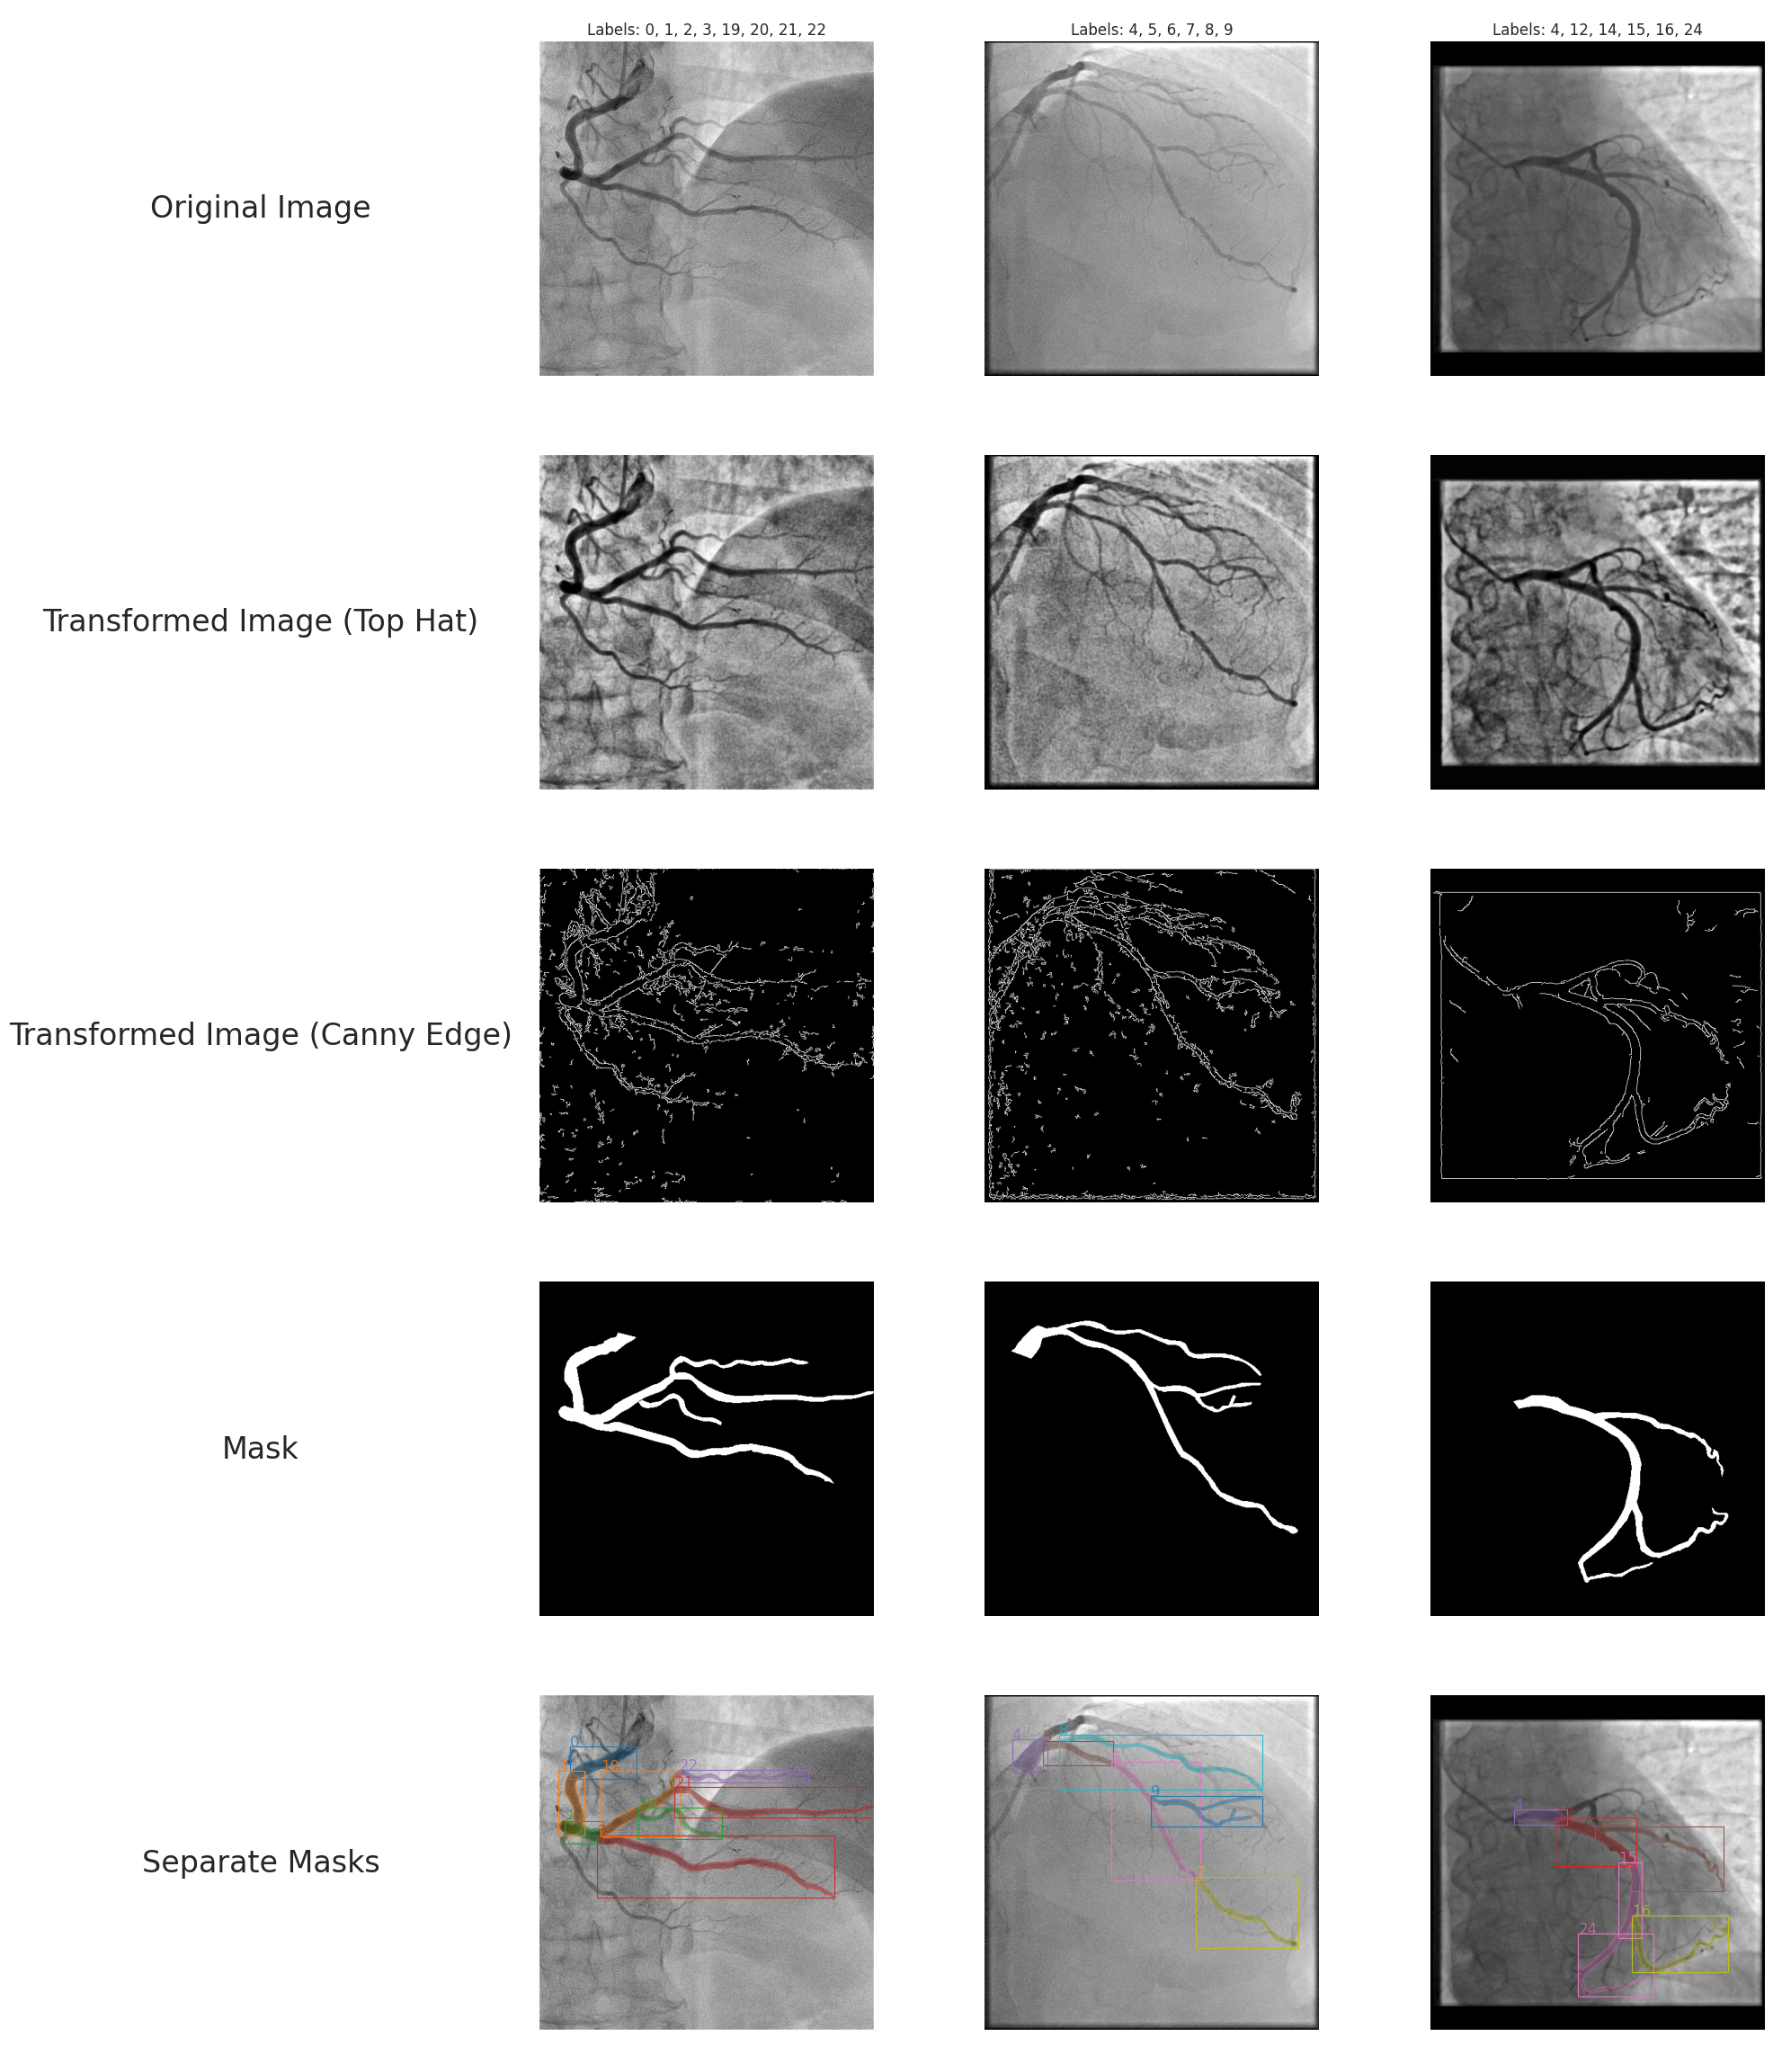

In [4]:
visualize_batch(batch, num_classes=25, num_images=3)
plt.savefig('plots/sample_batch.svg', format='svg', bbox_inches='tight')
plt.show()

### Label Distributions

In [20]:
datasets = {
    'train': (load_dataset('train'), 'r'),
    'val': (load_dataset('val'), 'g'),
    'test': (load_dataset('test'), 'b')
}

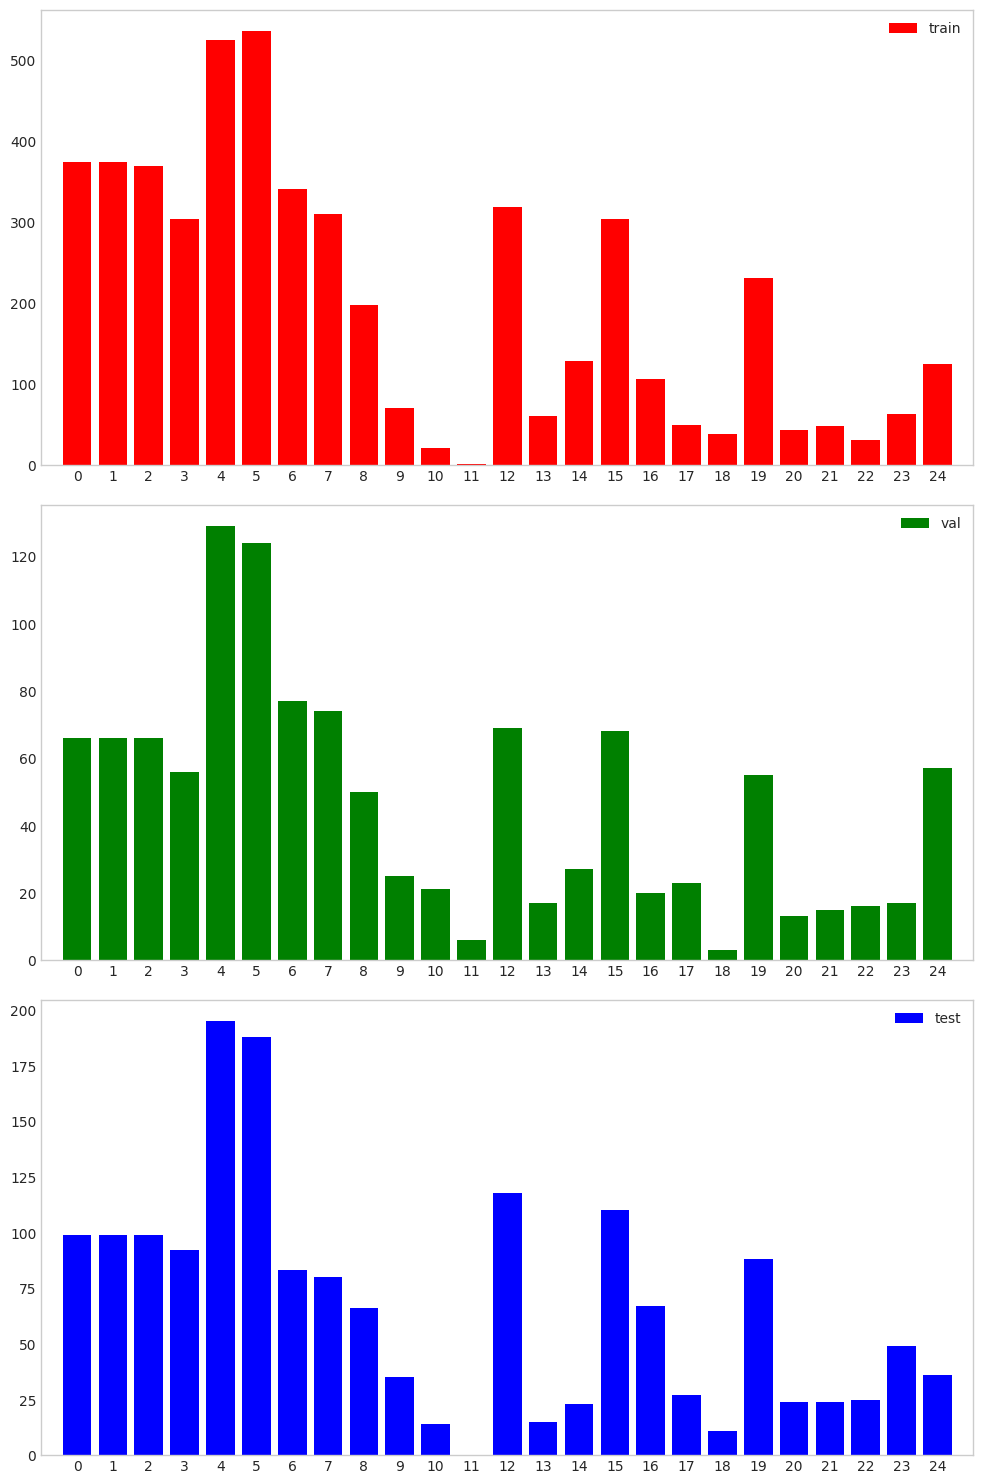

In [21]:
plt.subplots(3, 1, figsize=(10, 15))
plt.tight_layout()

for i, (split, (dataset, color)) in enumerate(datasets.items()):
    all_labels = [torch.where(x['labels'] > 0.5)[0] for x in dataset]
    all_labels = torch.cat(all_labels, dim=0)
    plt.subplot(3, 1, i + 1)
    plt.bar(*torch.unique(all_labels, return_counts=True), color=color, label=split)
    plt.xticks(range(25))
    plt.legend()
    plt.xlim(-1, 25)
    plt.gca().grid(False)
    plt.savefig('plots/label_distribution.svg', format='svg', bbox_inches='tight')
plt.show()

### Val F1 Lines

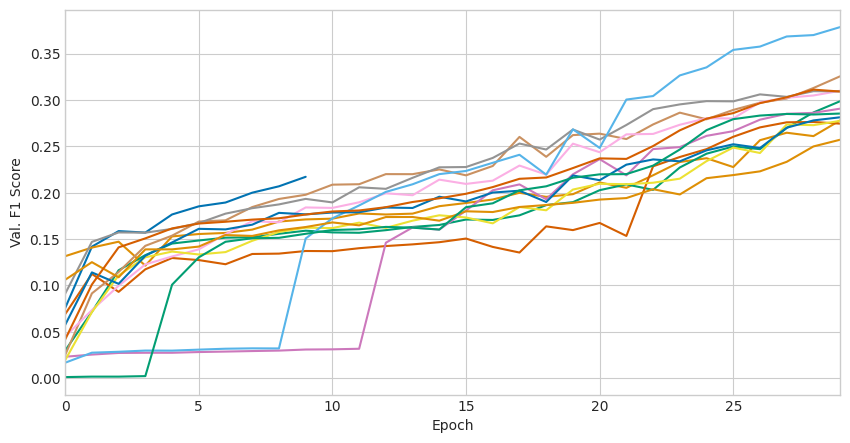

In [15]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 29)
for f1 in f1_s:
    plt.plot(f1)
plt.xlabel('Epoch')
plt.ylabel('Val. F1 Score')
plt.savefig('plots/sweep_f1.svg', format='svg', bbox_inches='tight')
plt.show()

### Full Run Loss Exploration

In [81]:
wandb.login()
api = wandb.Api()
best_run = 'oxwn02hh'
run = api.run(f"nlp-course-zvi-and-tomer/DMI2024B/runs/{best_run}")
val_f1 = run.scan_history(keys=['val_f1'])
train_loss = run.scan_history(keys=['train_loss'])
val_loss = run.scan_history(keys=['val_loss'])
reconstruction_loss = run.scan_history(keys=['reconstruction_loss'])
lr = run.scan_history(keys=['lr-Adam'])

In [84]:
val_f1 = [x['val_f1'] for x in val_f1]
train_loss = [x['train_loss'] for x in train_loss]
val_loss = [x['val_loss'] for x in val_loss]
reconstruction_loss = [x['reconstruction_loss'] for x in reconstruction_loss]
lr = [x['lr-Adam'] for x in lr]

In [117]:
# Smooth losses
def smooth(x, window=5):
    return pd.Series(x).rolling(window=window).mean()

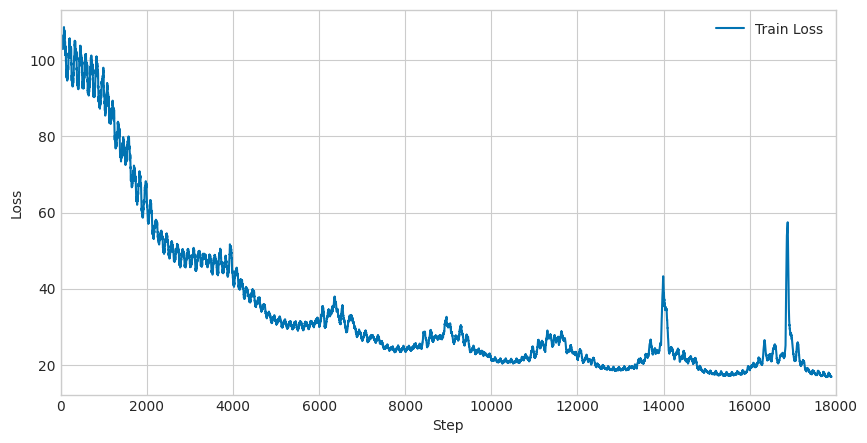

In [143]:
plt.figure(figsize=(10, 5))
plt.plot(smooth(train_loss[1000:-2000], 50), label='Train Loss')
plt.xlim(0, 18000)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.savefig('plots/train_loss.svg', format='svg', bbox_inches='tight')
plt.show()

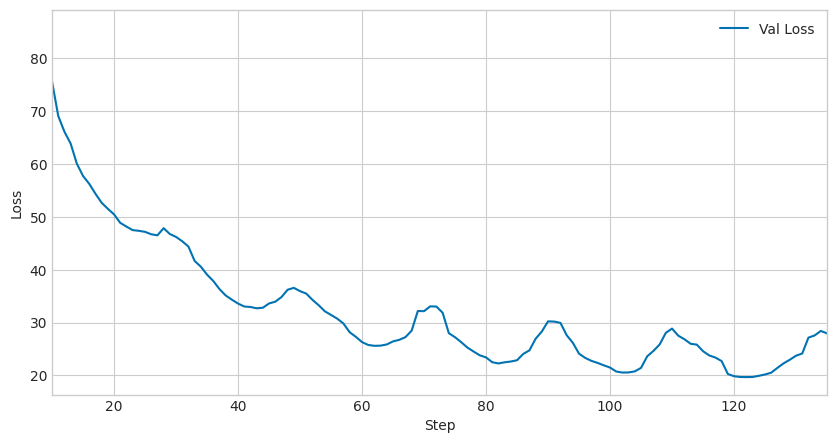

In [144]:
plt.figure(figsize=(10, 5))
plt.plot(smooth(val_loss[10:-20], 5), label='Val Loss')
plt.xlim(10, 135)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.savefig('plots/val_loss.svg', format='svg', bbox_inches='tight')
plt.show()

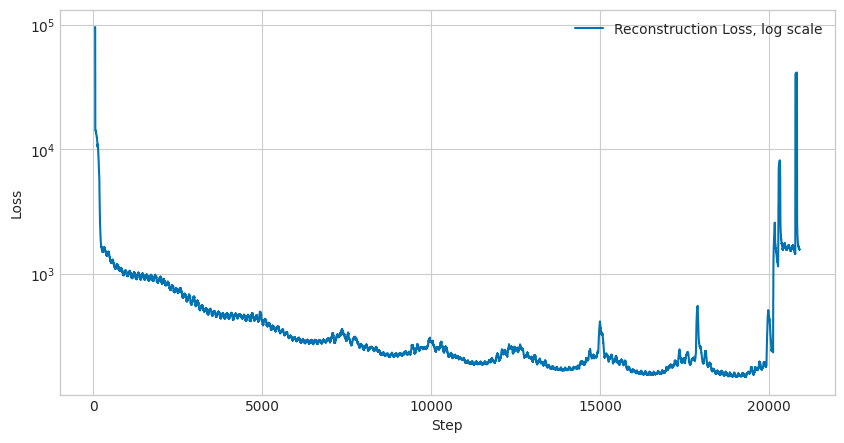

In [146]:
plt.figure(figsize=(10, 5))
plt.semilogy(smooth(reconstruction_loss, 50), label='Reconstruction Loss, log scale')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.savefig('plots/reconstruction_loss.svg', format='svg', bbox_inches='tight')

### Model Convs Viz.

In [50]:
train_dataset = load_dataset('train')

In [8]:
model = VesselSegmentationModel.load_from_checkpoint('models/final_model/oxwn02hh/epoch=152-step=19125.ckpt')
model.eval()

VesselSegmentationModel(
  (model): UNet(
    (encoder): UNetEncoder(
      (initial_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (blocks): ModuleList(
        (0): ResBlock(
          (residual): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (block): Sequential(
            (0): GroupNorm(8, 32, eps=1e-05, affine=True)
            (1): ReLU()
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): GroupNorm(8, 32, eps=1e-05, affine=True)
            (4): ReLU()
            (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (1): Sequential(
          (0): ResBlock(
            (residual): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
            (block): Sequential(
              (0): GroupNorm(8, 32, eps=1e-05, affine=True)
              (1): ReLU()
              (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

In [78]:
def extract_filter(model, block_idx, filter_idx):
    filter = model.model.encoder.blocks[block_idx][0].block[-1].weight[filter_idx, 0]
    return filter

In [81]:
extract_filter(model, 4, 0).size()

torch.Size([3, 3])

In [92]:
def loss(input_image, block_idx, filter_idx):
    features = extract_filter(model, block_idx, filter_idx)
    return -features.mean()

def optimize(input_image, block_idx, filter_idx, n_steps=1000, lr=0.1):
    input_image = input_image.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([input_image], lr=lr)

    for _ in tqdm(range(n_steps)):
        optimizer.zero_grad()
        l = loss(input_image, block_idx, filter_idx)
        l.backward()
        optimizer.step()
        input_image.data.clamp_(0, 1)
    return input_image

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

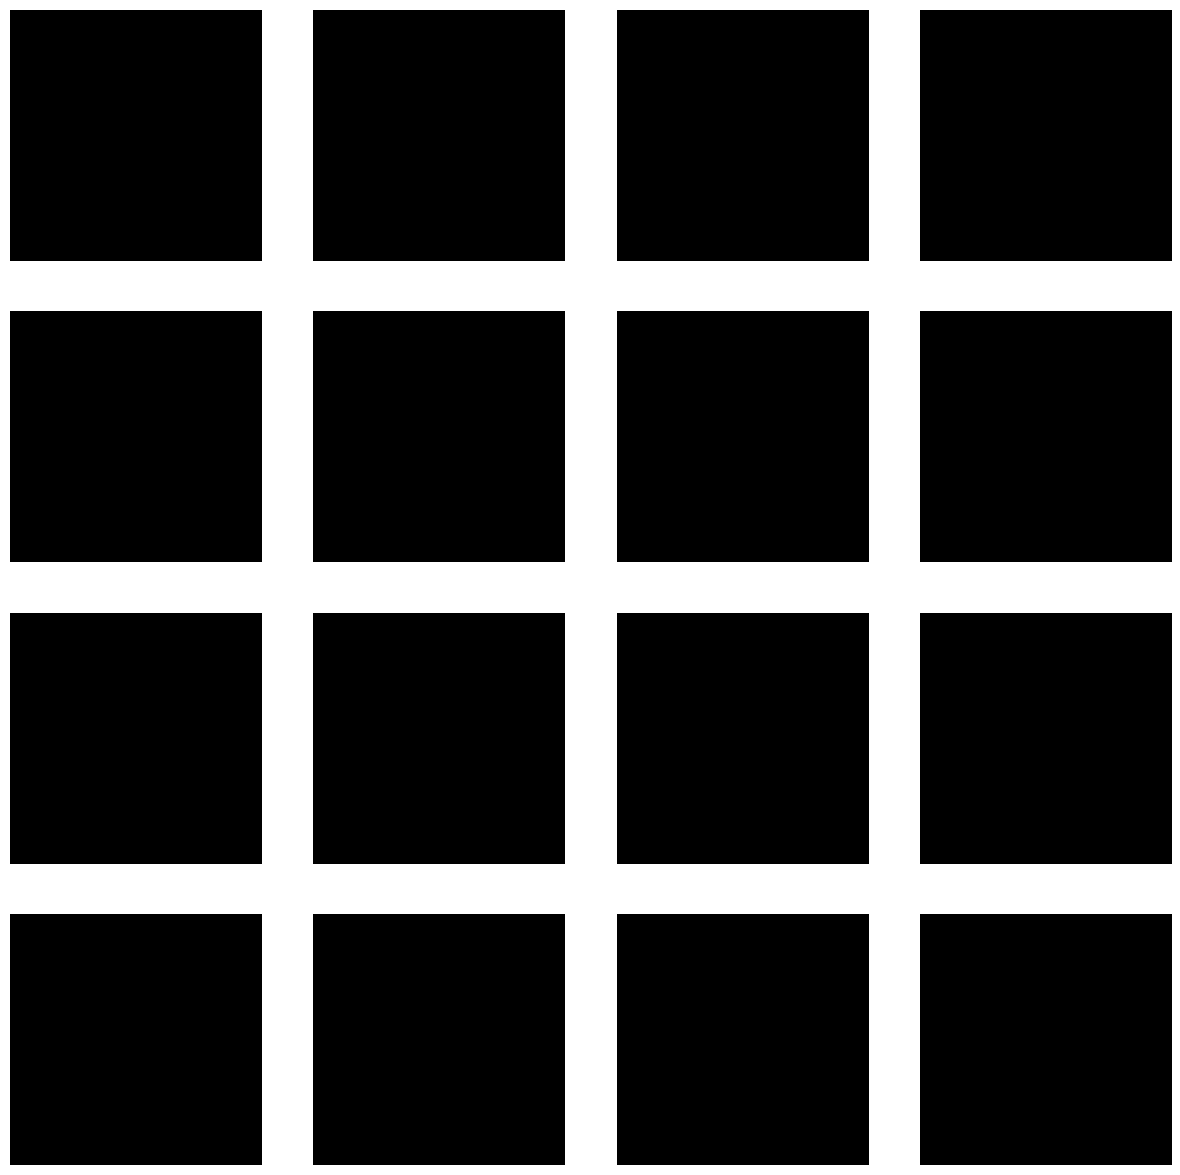

In [93]:
img = train_dataset[0]['original_image'].to(model.device)

# Optimize the input image to maximize the activation of the filter
block_idx = 4
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for filter_idx in range(16):
    optimized_img = optimize(img, block_idx, filter_idx, n_steps=100, lr=1e-2)
    axs[filter_idx // 4, filter_idx % 4].imshow(optimized_img.squeeze().detach().cpu().numpy(), cmap='gray')
    axs[filter_idx // 4, filter_idx % 4].axis('off')
plt.savefig('plots/filter_activation_maximization_visualization.svg', format='svg', bbox_inches='tight')
plt.show()